# Analysis

For each query specified in the assignment, compute the answers. Include a plot of
these results in this notebook. Briefly discuss what you can observe from these results. Beware that for some queries, not all of the sub-dataset types have the information required to answer the query. In that case, please ignore those sub-datasets

In [1]:
# Imports go here
import os
import glob
import pandas as pd
import os 
import shutil
import datetime
import geopandas as gpd
from datetime import date
from datetime import datetime
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as f
from pyspark.sql.functions import hour, mean
from shutil import copyfile
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=3g  pyspark-shell"
from pyspark.sql import SparkSession
try: 
    spark
    print("Spark application already started. Terminating existing application and starting new one")
    spark.stop()
except: 
    pass
# Create a new spark session (note, the * indicates to use all available CPU cores)
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("H600 L-Group") \
    .getOrCreate()
#When dealing with RDDs, we work the sparkContext object. See https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext
sc=spark.sparkContext
#in local mode, you will be able to access the Spark GUI at http://localhost:4040

## Declaration of usefull functions and parameters

In [2]:
## FUNCTION DECLARATION
# Creation of a function to convert lat-lon into location ID
def convertlocID(lon, lat):
    """
    This function define the location ID from the latitude and longitude coordinates.
    It assumes that the files taxis_zones.shp is already loaded and converted unsing the epsg 4326 projection.
    
    Input: the latitude and longitude.      
    Output: the locationID deduce from GPS positions.
    """  
    global locationID # access the outer scope variable by declaring it global
    if lon != None and lat != None and lon < -73.0 and lon > -75.0 and lat > 40.0 and lat < 42.0:
        query_point = Point( lon, lat)
        possible_matches = list(rtree.intersection( query_point.bounds ))
        for i in range(0,len(possible_matches)) :
            if zones.iloc[possible_matches[i]].geometry.contains(query_point) == True :
                locationID = possible_matches[i]
    else:
        locationID = 9999
    
    return locationID

# Check if the value is null or not
def blank_as_null(x):
    """
    This function define blank as null in order to be more easily interpreted.
    
    Input: the column name that need to be check      
    Output: the column corrected
    """  
    return f.when(col(x).isNull(), 0 ).otherwise(col(x))

def create_files_list(path, brand, list_files):
    """
    This function create the files list of specify taxi brand (brand) from the specify folder (path). 
    
    Input: the path where are the files -> /data/cleaned or data/sampled
           the name of the taxi company -> fhv, fhvfh, green, yellow
           the empty file name list in which each file will be append
    Output: number of files in the list and the list of files name.
    """  
    global nb_files
    nb_files = 0
    for file in glob.glob("%s/%s_*.csv" %(path,brand)):
        nb_files = nb_files+1
        # Save in list the files name
        list_files.append(file)
        # Order by date the file list
        list_files.sort()

    return list_files, nb_files

def get_locID_fromzone(x,zone_name) :
    """
    This function look for particular regions in the dateframe and save the list of location ID
    
    Input: the dataframe (x) and the location name (zone_name).      
    Output: the locationID of for this name.
    """  
    locID = x.where((col("borough") == zone_name) ).select(col("LocationID"))
    locID = [row[0] for row in locID.select("LocationID").collect()]

    return locID  

def create_date_range(yr,mth) :
    """
    This function prodide the datetime var of the 1st day and a datetime var 
    for the last day of the same month for on a specific year.
    
    Input: the year and the month     
    Output: date1 for 1st day of the month
            date2 for last day of the month
    """  
    end_mth = mth + 1
    date1=pd.to_datetime('%s-%s-01 00:00:00' %(yr,mth))
    if end_mth == 13 :
        date2=pd.to_datetime('%s-12-31 00:00:00' %(yr))
    else :
        date2=pd.to_datetime('%s-%s-01 00:00:00' %(yr,end_mth))
    
    return date1, date2

## PARAMETERS DECLARATION
cl_path = "data/cleaned/"

## 1. Taxis companies popularity

How the popularity of a particular service (Yellow Taxi, Green Taxi, FHV, FHVHV) is evolving over time? 

In [60]:
# Get the numbers of trips by months for each taxi compagnies
list_taxi = ["fhv", "fhvhv", "yellow", "green"]
list_taxi = ["green"]
list_year = {}
month_list = {}
var = {}
for taxi_brand in list_taxi :
    print(taxi_brand)
    list_year[taxi_brand] = []
    month_list[taxi_brand] = []
    var[taxi_brand] = []
    # Get the list of the file for each taxi
    DF = (spark.read
                    .option("sep", ",")
                    .option("header", True)
                    .option("inferSchema", True)
                    .csv(cl_path+taxi_brand+"/*.csv") )
    # Get the date of each lines and get the list of years
    DF = DF.orderBy("pickup_datetime")
    year_extract = DF.selectExpr("year(pickup_datetime) AS year", "pickup_datetime").groupBy("year").sum().orderBy("year").select("year")
    list_year[taxi_brand] = [row[0] for row in year_extract.select('year').collect()])
    # For each years of the files, compute the monthly sum of the trips
    for yr in list_year[taxi_brand] :
        test = DF.where(f.year("pickup_datetime")==yr)\
                        .selectExpr("month(pickup_datetime) AS month", "pickup_datetime")\
                        .groupBy("month").count().orderBy("month")
        var[taxi_brand].append([row[0] for row in test.select('count').collect()])
        month_list[taxi_brand].append([row[0] for row in test.select('month').collect()])


fhv
root
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- PULocationID: double (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- SR_Flag: string (nullable = true)

None
[2015, 2016, 2017, 2018, 2019, 2020]
fhvhv
root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: integer (nullable = true)

None
[2019, 2020]
yellow
root
 |-- vendorid: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- ratecodeid: string (nullable = true)
 |-- store_and_fwd_flag: str

In [136]:
locID = zones_df.select(col("LocationID"))
locID = [row[0] for row in locID.select("LocationID").collect()]
print(locID)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 103, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [70]:
# Get the values of each months for each years of the taxi compagnies in order to plot them.
list_taxi = ["fhv", "fhvhv", "green", "yellow"]
time = {}
summing = {}
dating = {}
maxi = 0
for taxi_brand in list_taxi :
    print(taxi_brand)
    time[taxi_brand] = []
    summing[taxi_brand] = []
    dating[taxi_brand] = []
    for y in range(0,len(month_list[taxi_brand])) :
        for m in range(len(month_list[taxi_brand][y])) :
            timing = str(list_year[taxi_brand][y])+"/"+str(month_list[taxi_brand][y][m])+"/1"
            time[taxi_brand].append(timing) 
            summing[taxi_brand].append(var[taxi_brand][y][m])
            maxi = max(maxi, max(summing[taxi_brand]))
    dating[taxi_brand] = pd.to_datetime(time[taxi_brand], infer_datetime_format=True)



fhv
fhvhv
green
yellow


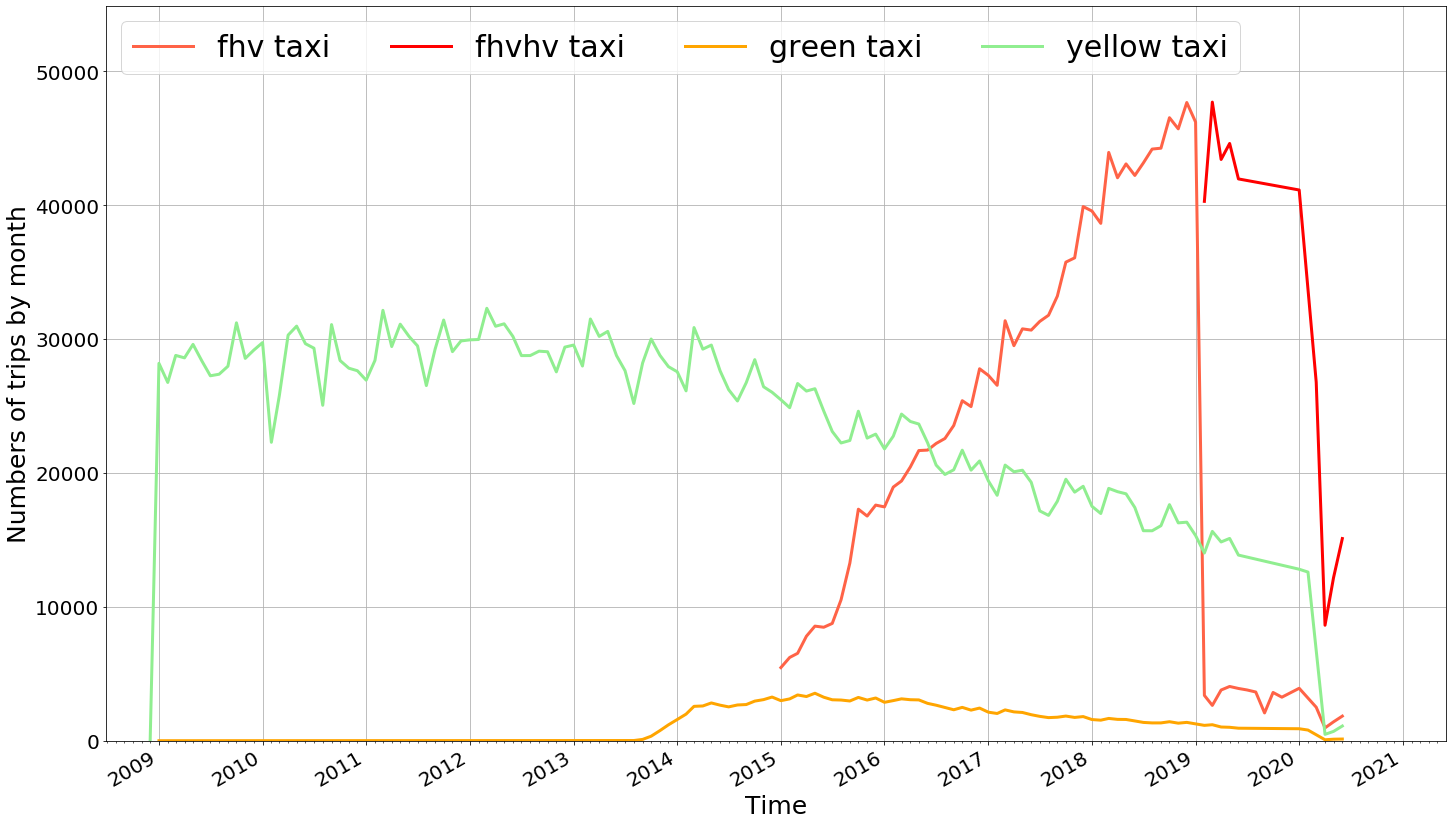

In [63]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'legend.fontsize': 30,
          'xtick.labelsize': 20,
          'ytick.labelsize':20}
plt.rcParams.update(parameters)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y') # xlabel only the year
# To get color list
overlap = {name for name in mcolors.CSS4_COLORS if "xkcd:" + name in mcolors.XKCD_COLORS}
# Create date frame from the time axis
rng = pd.date_range('2008-06-15', periods=13*12, freq='m')
xmin = rng[0]
xmax = rng[-1]

# Plot the numbers of monthly number of trips 
i = 0
fig, ax = plt.subplots(1,figsize=(24,15))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
for taxi_brand in list_taxi :
    i = i+6
    colors = (sorted(overlap,reverse=True))[i]
    ax.plot(dating[taxi_brand],summing[taxi_brand],color=colors,label='%s taxi' %(taxi_brand),lw=3) # Line not visible, only to show values
ax.set_xlim(xmin,xmax,1)
ax.set_ylim(0,round(maxi+(maxi*0.15)))
ax.set_xlabel("Time")
ax.set_ylabel("Numbers of trips by month")
ax.format_ydata = lambda x: '$%1.2f' % x
ax.grid(True)
plt.legend(ncol=4,loc=2)
fig.autofmt_xdate()


From the figure above, we can see that for the Yellow taxi compagny, even if there are montlhy variation in the numbers of trips, between 2009 and begining of 2012 the number of trip sliglhy increase. Then from this date the number of trips with the Yellow taxi starts to decrease and this lower number of monthly trips amplifies in begening of 2014 when the Green taxi compagny appears on the market. Starting in 2015, and in less than 4 years, the montlhy number of trips of the FHV taxis compagnies explode, to reach less than 50 000 mensual trips. In the mean time, the Yellow taxi compagny continue its decline. Regarding the Green compagny taxi, after a plateau of around 3000 monthly trips, the decline of this number follows the explosion of the FHV trips. In 2019, the FHV compagnies are slipt in High Volume FHV (called on the plot FHVHV) and others FHV compagnies doing fewer dayly trips. This split explains the big drop in January 2019. From 2019, the FHV and FHVHV had stable monthly number of trips, until the COVID-19 appears in March 2020. the effect is a  an abrupt decrease of the number of trip for all the Taxi compagnies. Then in April 2020, the number of trips for all taxi compagnies seems increase, but need to be confirmed over more months. 

## 2. Taxis companies popularity in Manhattan and Brooklyn.

How the popularity of a particular service (Yellow Taxi, Green Taxi, FHV, FHVHV) is evolving over time in Manhattan and Brooklyn? 

In [165]:
# Load the shapefile, this yields a GeoDataFrame that has a row for each zone
zones = gpd.read_file('data/metadata/taxi_zones.shp')
zones_df = spark.createDataFrame(zones).cache()


list_taxi = ["fhv", "fhvhv", "yellow", "green"]
list_year = {}
month_list = {}
var = {}
for taxi_brand in list_taxi :
    # Get the list of the file for each taxi
    DF = (spark.read
                    .option("sep", ",")
                    .option("header", True)
                    .option("inferSchema", True)
                    .csv(cl_path+taxi_brand+"/*.csv") )
    print(DF.printSchema())
    for zones in ["Manhattan" , "Brooklyn"] :
        var_name = taxi_brand+"-"+zones
        print(var_name)
        list_year[var_name] = []
        month_list[var_name] = []
        var[var_name] = []
        # LocationID for Manhattan
        locID = get_locID_fromzone(zones_df, zones)
        select_zone = DF.where(col("pulocationid").isin(locID)).select(col("pickup_datetime"))
        # Get the date of each lines and get the list of years
        select_zone = select_zone.orderBy("pickup_datetime")
        year_extract = select_zone.selectExpr("year(pickup_datetime) AS year", "pickup_datetime").groupBy("year").sum().orderBy("year").select("year")
        list_year[var_name] = [row[0] for row in year_extract.select('year').collect()]
        # For each years of the files, compute the monthly sum of the trips
        for yr in list_year[var_name] :
            test = select_zone.where(f.year("pickup_datetime")==yr)\
                            .selectExpr("month(pickup_datetime) AS month", "pickup_datetime")\
                            .groupBy("month").count().orderBy("month")
            var[var_name].append([row[0] for row in test.select('count').collect()])
            month_list[var_name].append([row[0] for row in test.select('month').collect()])


        
        
      

root
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- PULocationID: double (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- SR_Flag: string (nullable = true)

None
fhv-Manhattan
fhv-Brooklyn
root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: integer (nullable = true)

None
fhvhv-Manhattan
fhvhv-Brooklyn
root
 |-- vendorid: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- ratecodeid: string (nullable = true)
 |-- store_and_fwd_flag: string (null

In [166]:
list_taxi = ["fhv", "fhvhv", "yellow", "green"]
time = {}
summing = {}
dating = {}
maxi = 0
for taxi_brand in list_taxi :
    for zones in ["Manhattan" , "Brooklyn"] :
        var_name = taxi_brand+"-"+zones
        print(var_name)
        time[var_name] = []
        summing[var_name] = []
        dating[var_name] = []
        for y in range(0,len(month_list[var_name])) :
            for m in range(len(month_list[var_name][y])) :
                timing = str(list_year[var_name][y])+"/"+str(month_list[var_name][y][m])+"/1"
                time[var_name].append(timing) 
                summing[var_name].append(var[var_name][y][m])
                maxi = max(maxi, max(summing[var_name]))
        dating[var_name] = pd.to_datetime(time[var_name], infer_datetime_format=True)

fhv-Manhattan
fhv-Brooklyn
fhvhv-Manhattan
fhvhv-Brooklyn
yellow-Manhattan
yellow-Brooklyn
green-Manhattan
green-Brooklyn


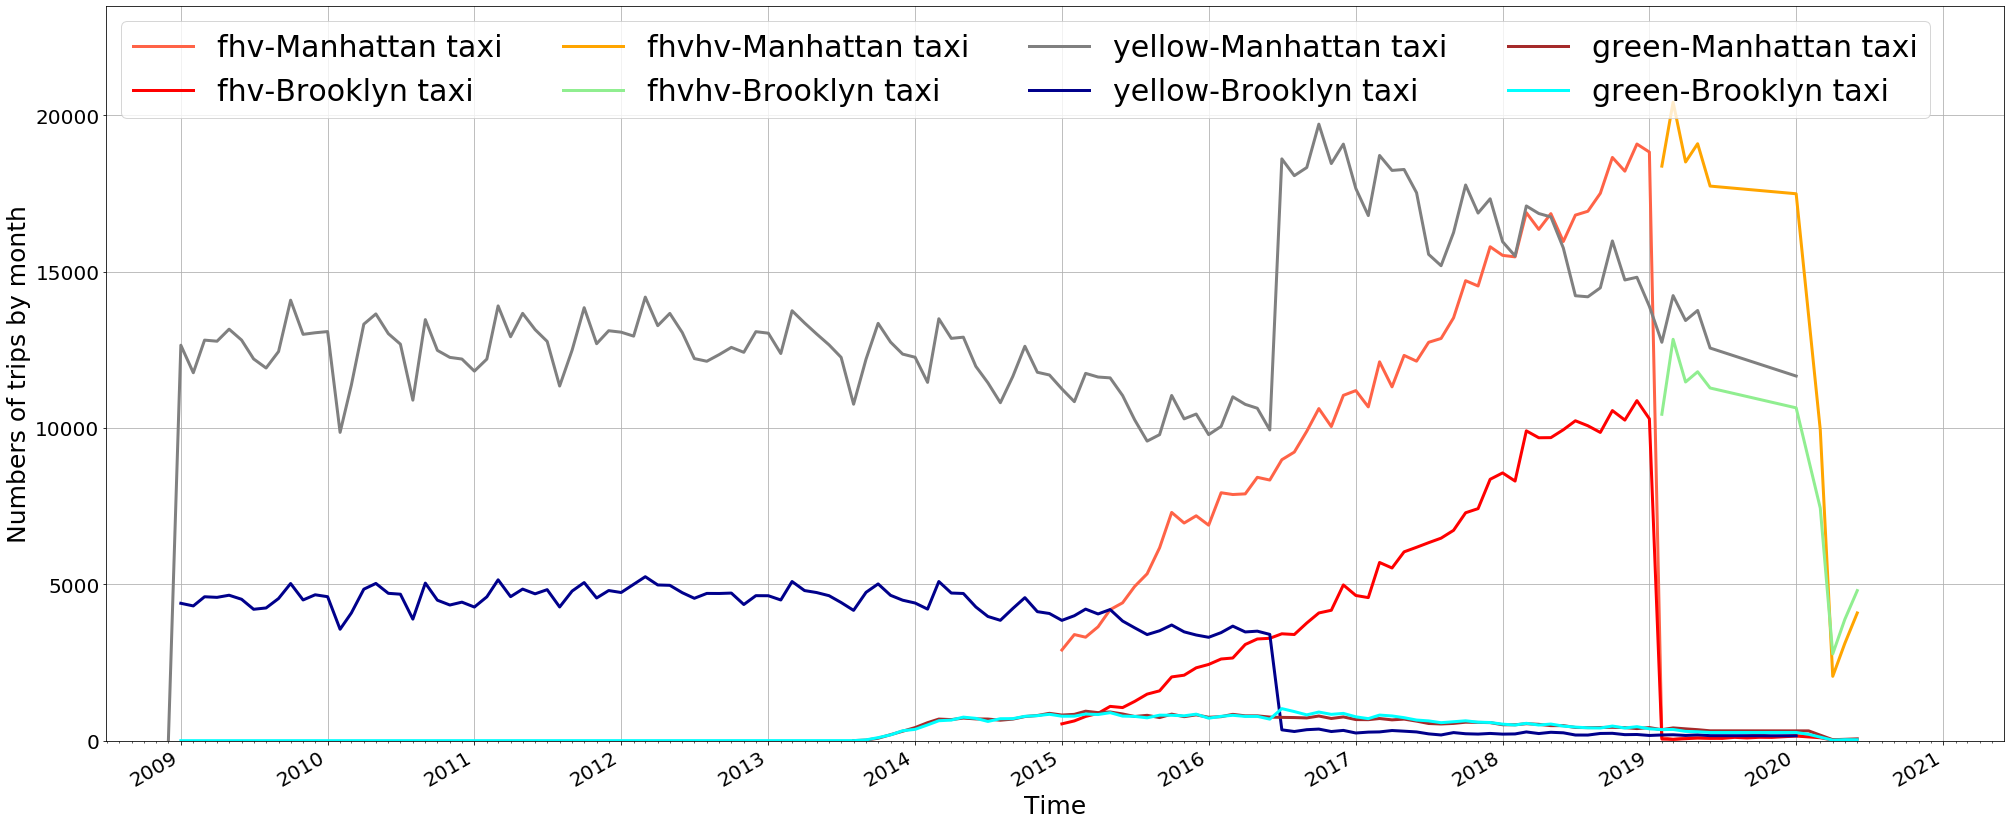

In [170]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'legend.fontsize': 30,
          'xtick.labelsize': 20,
          'ytick.labelsize':20}
plt.rcParams.update(parameters)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y') # xlabel only the year
# To get color list
overlap = {name for name in mcolors.CSS4_COLORS if "xkcd:" + name in mcolors.XKCD_COLORS}
# Create date frame from the time axis
rng = pd.date_range('2008-06-15', periods=13*12, freq='m')
xmin = rng[0]
xmax = rng[-1]

# Plot the numbers of monthly number of trips 
i = 0
fig, ax = plt.subplots(1,figsize=(34,15))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
for taxi_brand in list_taxi :
    for zones in ["Manhattan" , "Brooklyn"] :
        var_name = taxi_brand+"-"+zones
        i = i+6
        colors = (sorted(overlap,reverse=True))[i]
        ax.plot(dating[var_name],summing[var_name],color=colors,label='%s taxi' %(var_name),lw=3) # Line not visible, only to show values
ax.set_xlim(xmin,xmax,1)
ax.set_ylim(0,round(maxi+(maxi*0.15)))
ax.set_xlabel("Time")
ax.set_ylabel("Numbers of trips by month")
ax.format_ydata = lambda x: '$%1.2f' % x
ax.grid(True)
plt.legend(ncol=4,loc=2)
fig.autofmt_xdate()


## 3. Which taxi compagny  is making the most revenue ?

Which service provider between Yellow Taxi, Green Taxi, FHV and FHVHV is making the most revenue ? Revenu is the sum over all receipts in the same month of fares, surcharges, taxes and tolls. It not includes tips. Following the schema of the data we previously decide, the revenu is the total_amoumt minus the tip_amount.

##### WARNING: only Yellow and Green taxi compagnies have revenue informations. 

In [315]:
list_taxi = [ "yellow", "green"]
list_year = {}
dating = {}
var = {}
for taxi_brand in list_taxi :
    print(taxi_brand)
    list_year[taxi_brand] = []
    var[taxi_brand] = []
    dating[taxi_brand] = []
    # Get the list of the file for each taxi
    DF = (spark.read
                    .option("sep", ",")
                    .option("header", True)
                    .option("inferSchema", True)
                    .csv(cl_path+taxi_brand+"/*.csv") )
    # Get the date of each lines and get the list of years
    DF = DF.withColumn("revenue", (col("total_amount") - col("tip_amount")))
    DF = DF.orderBy("pickup_datetime")
    year_extract = DF.selectExpr("year(pickup_datetime) AS year", "pickup_datetime").groupBy("year").sum().orderBy("year").select("year")
    list_year[taxi_brand] = [row[0] for row in year_extract.select('year').collect()]
    # For each years of the files, compute the monthly sum of the trips
    for yr in [2015,2016] :
        for mth in range(1,13,1):
            print(yr,mth)
            date1, date2 = create_date_range(yr,mth)
            test = DF.filter(col("pickup_datetime").between(date1,date2)).select(f.sum(col("revenue"))).collect()
            var[taxi_brand].append([row[0] for row in test])
            dating[taxi_brand].append(date1+timedelta(days=14))

yellow
2015 1
2015 2
2015 3
2015 4
2015 5
2015 6
2015 7
2015 8
2015 9
2015 10
2015 11
2015 12
2016 1
2016 2
2016 3
2016 4
2016 5
2016 6
2016 7
2016 8
2016 9
2016 10
2016 11
2016 12
green
2015 1
2015 2
2015 3
2015 4
2015 5
2015 6
2015 7
2015 8
2015 9
2015 10
2015 11
2015 12
2016 1
2016 2
2016 3
2016 4
2016 5
2016 6
2016 7
2016 8
2016 9
2016 10
2016 11
2016 12


In [321]:
print(var[taxi_brand])

[[339456.1599999992], [339339.61999999936], [374942.24999999924], [373451.3299999993], [386137.61999999906], [360578.2199999991], [331341.7599999992], [322344.87999999925], [329006.2299999994], [361058.9199999992], [330721.94999999943], [323190.0199999995], [302648.4199999994], [313250.0799999993], [347093.0599999995], [343817.9199999995], [349619.94999999925], [328573.7399999992], [302483.7799999995], [291377.0699999995], [304643.13999999926], [320273.73999999935], [295158.5899999994], [292580.2199999995]]


In [317]:
time = {}
summing = {}
maxi = 0
for taxi_brand in list_taxi :
    print(taxi_brand)
    time[taxi_brand] = []
    summing[taxi_brand] = []
    for y in range(0,len(var[taxi_brand])) :
        print(y)
        for m in range(len(var[taxi_brand][y])) :
            timing = str(list_year[taxi_brand][y])+"/"+str(month_list[taxi_brand][y][m])+"/1"
            time[taxi_brand].append(timing) 
            summing[taxi_brand].append(var[taxi_brand][y][m])
            maxi = max(maxi, max(summing[taxi_brand]))

yellow
0


KeyError: 'yellow'

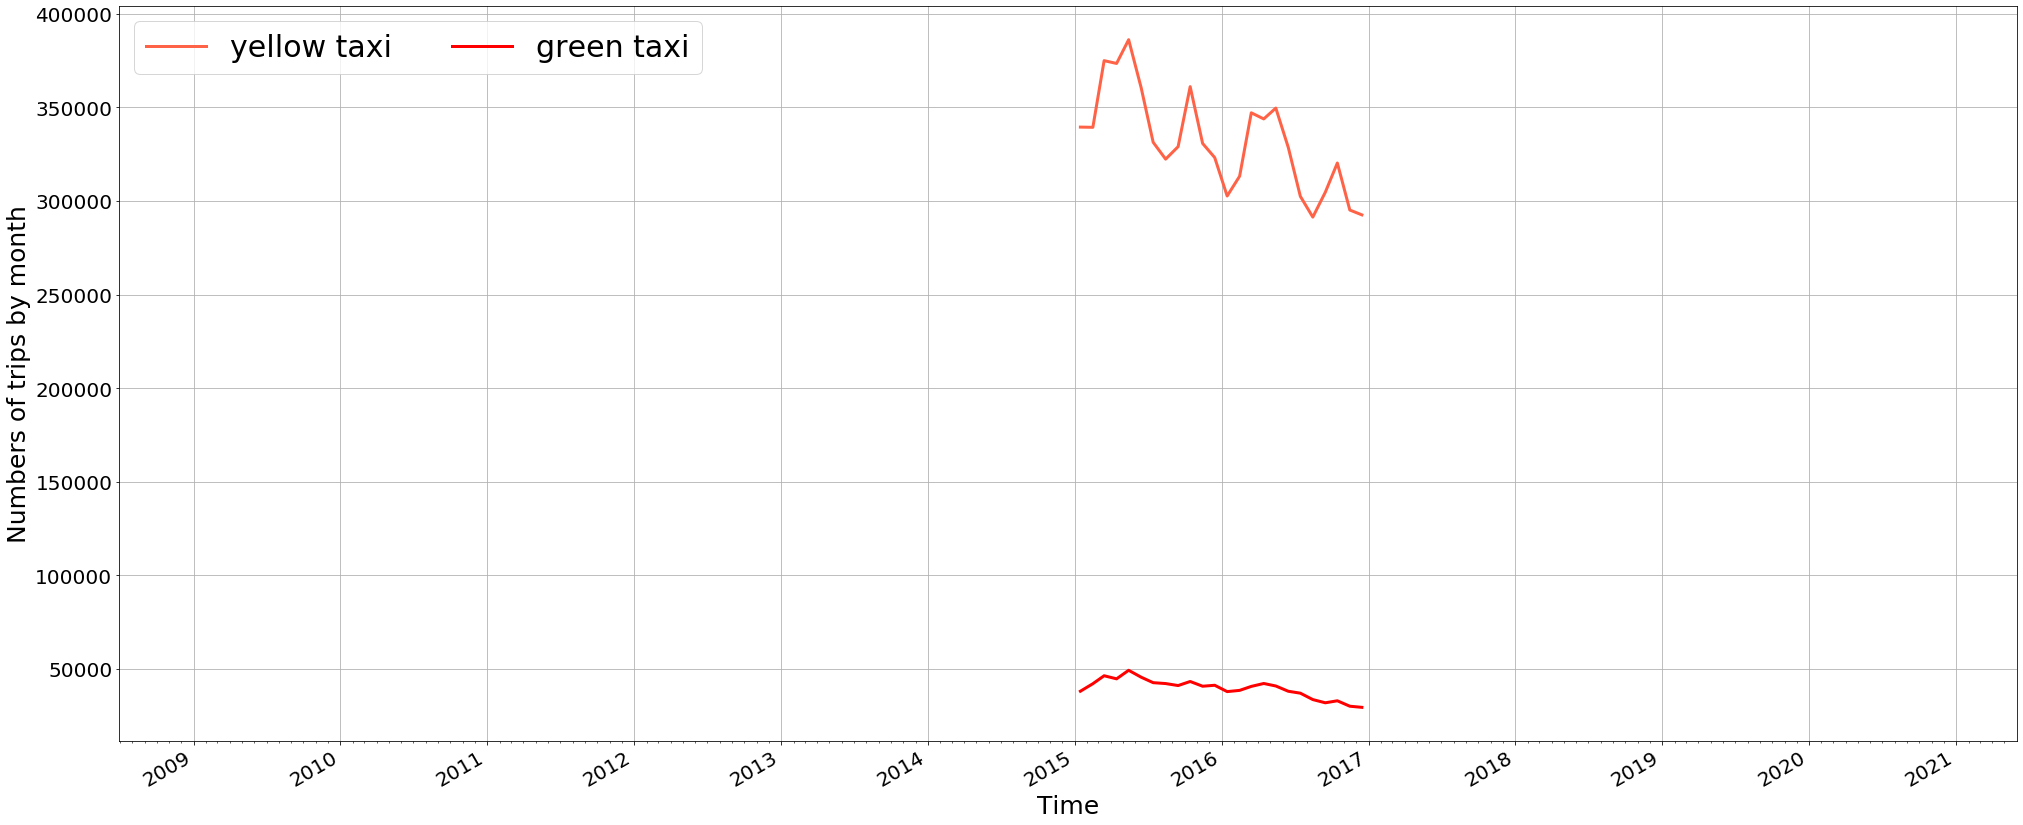

In [322]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'legend.fontsize': 30,
          'xtick.labelsize': 20,
          'ytick.labelsize':20}
plt.rcParams.update(parameters)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y') # xlabel only the year
# To get color list
overlap = {name for name in mcolors.CSS4_COLORS if "xkcd:" + name in mcolors.XKCD_COLORS}
# Create date frame from the time axis
rng = pd.date_range('2008-06-15', periods=13*12, freq='m')
xmin = rng[0]
xmax = rng[-1]

# Plot the numbers of monthly number of trips 
i = 0
fig, ax = plt.subplots(1,figsize=(34,15))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
for taxi_brand in ['yellow','green'] :
    i = i+6
    colors = (sorted(overlap,reverse=True))[i]
    ax.plot(dating[taxi_brand],var[taxi_brand],color=colors,label='%s taxi' %(taxi_brand),lw=3) # Line not visible, only to show values
ax.set_xlim(xmin,xmax,1)
#ax.set_ylim(0,)
ax.set_xlabel("Time")
ax.set_ylabel("Numbers of trips by month")
ax.format_ydata = lambda x: '$%1.2f' % x
ax.grid(True)
plt.legend(ncol=4,loc=2)
fig.autofmt_xdate()